In this extension of `2AE_PCA.ipynb`, I implement a deeper autoencoder using nonlinear activations to bridge the gap with the `3VAE.ipynb` notebook. The AE-SVD equivalence with PCA breaks down and the projection to obtain the scores no longer makes sense, since the model now is nonlinear. A weak robustness analysis is carried out at the bottom of the notebook, which shows that the FRED-MD regressions (unsurprisingly) are inconsistent when varying the random seed being used to train the networks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers, models, optimizers
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
from utils.plotting_utils import plot_latent_space_trajectory_3d_static, plot_keras_training_loss, plot_marginal_r_squares
from utils.data_utils import load_yield_data, load_fred_md
from utils.seed_utils import set_random_seed
set_random_seed(1)


yield_data = load_yield_data()
FIRST_DATE = yield_data.index.min() - pd.DateOffset(months=1)
LAST_DATE = yield_data.index.max()

In [2]:
def analyticalPCA(y, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(y)
    return pca.components_, pca.transform(y)

def deepNonlinearAE(y, dimension=3, hidden_dims=[64, 32], 
                    learning_rate=1e-4, regularization=5e-4, 
                    epochs=100, activation='relu'):
    """Train a deep nonlinear autoencoder on yield data y to extract 'dimension' factors. """
    input_layer = Input(shape=(y.shape[1],))
    
    # Encoder:
    encoded = input_layer
    for hidden_dim in hidden_dims:
        encoded = Dense(hidden_dim, activation=activation,
                       kernel_regularizer=regularizers.l2(regularization))(encoded)
    
    latent = Dense(dimension, activation='linear', name='latent',
                   kernel_regularizer=regularizers.l2(regularization))(encoded)
    
    # Decoder:
    decoded = latent
    for hidden_dim in reversed(hidden_dims):
        decoded = Dense(hidden_dim, activation=activation,
                       kernel_regularizer=regularizers.l2(regularization))(decoded)
    
    output_layer = Dense(y.shape[1], activation='linear',
                        kernel_regularizer=regularizers.l2(regularization))(decoded)
    
    autoencoder = models.Model(input_layer, output_layer)
    encoder = models.Model(input_layer, latent)
    
    # Compile and train
    autoencoder.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
                       loss='mean_squared_error')
    
    history = autoencoder.fit(
        y, y,
        epochs=epochs,
        batch_size=32,
        shuffle=True,
        verbose=2
    )
    
    return encoder, autoencoder, history

def get_deep_ae_scores(encoder, y_normalized):
    """For deep AE, simply use the encoder to get latent representations."""
    scores = encoder.predict(y_normalized, verbose=0)
    return scores

Calculate the PCA and linear AE factors:

In [ ]:
# Convert yield data to numpy array and normalize
y = yield_data.values.astype('float32')
# Standardize the data (mean=0, std=1 for each maturity)
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
y_normalized = (y - y_mean) / y_std
p_analytical, pca_scores = analyticalPCA(y_normalized, dimension=3)

encoder_deep, ae_deep, history_deep = deepNonlinearAE(
    y_normalized, 
    dimension=3,
    hidden_dims=[64, 32, 16],
    learning_rate=1e-3,
    regularization=1e-5,
    epochs=100,
    activation='relu'
)

(For completeness, I also plot the training loss, though it is not very interesting here)

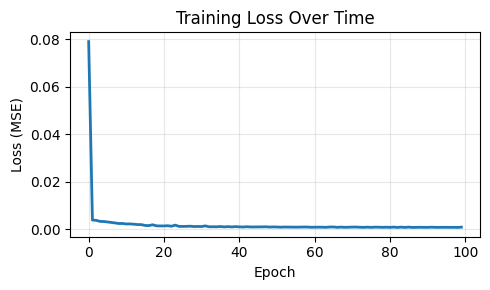

In [4]:
plot_keras_training_loss(history_deep)

Next, I plot the nonlinear latent factor scores against the PCA scores.

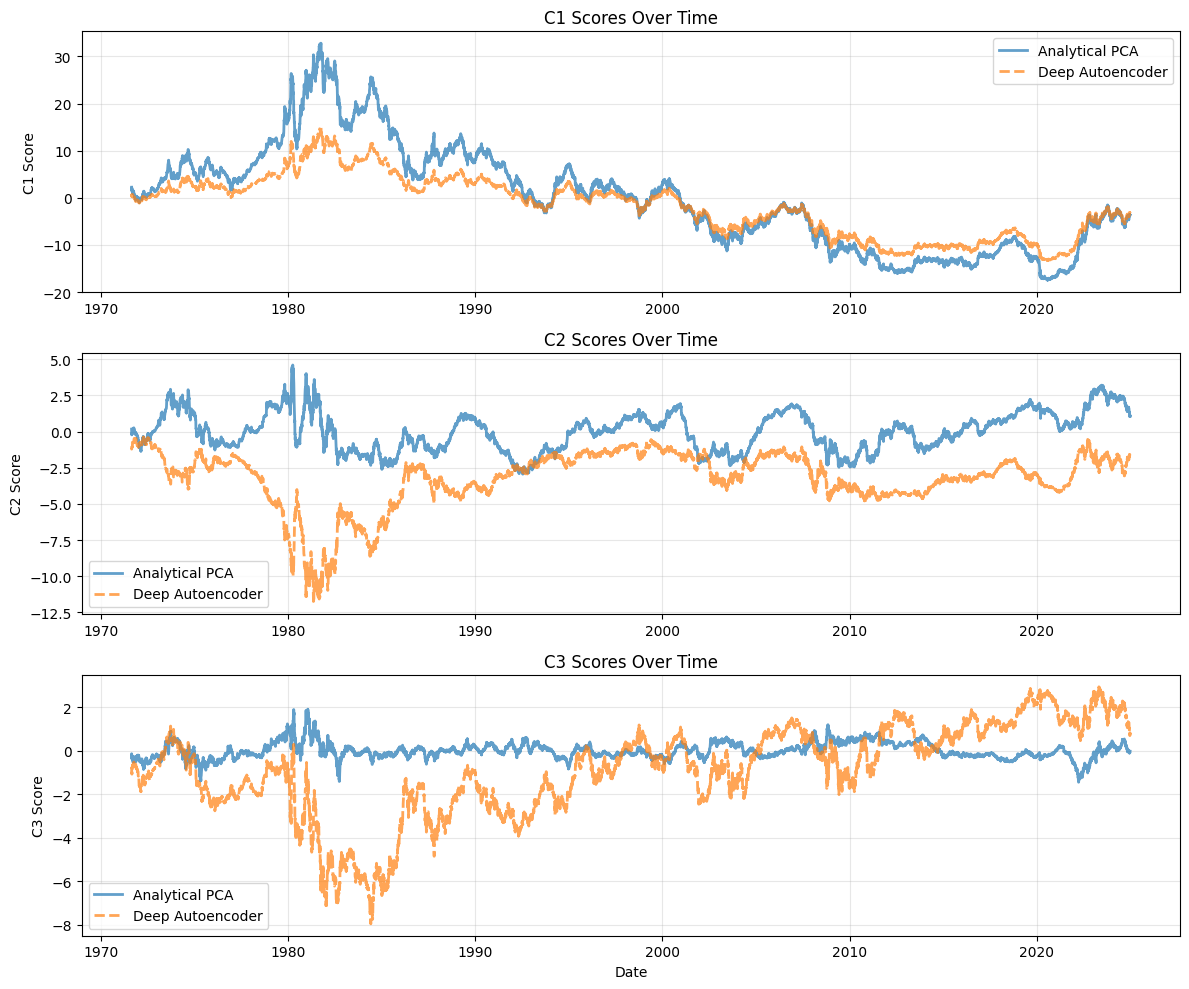

In [5]:
# Extract deep AE scores using the encoder
deep_ae_scores = get_deep_ae_scores(encoder_deep, y_normalized)

pca_scores_df = pd.DataFrame(
    pca_scores,
    index=yield_data.index,
    columns=['C1', 'C2', 'C3']
)

deep_ae_scores_df = pd.DataFrame(
    deep_ae_scores,
    index=yield_data.index,
    columns=['C1', 'C2', 'C3']
)

# Write deep AE scores to csv
deep_ae_scores_df.to_csv(r'scores/deep_ae_scores.csv')

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i, pc in enumerate(['C1', 'C2', 'C3']):
    axes[i].plot(pca_scores_df.index, pca_scores_df[pc], 
                 label='Analytical PCA', alpha=0.7, linewidth=2)
    axes[i].plot(deep_ae_scores_df.index, deep_ae_scores_df[pc], 
                 label='Deep Autoencoder', alpha=0.7, linewidth=2, linestyle='--')
    axes[i].set_ylabel(f'{pc} Score')
    axes[i].set_title(f'{pc} Scores Over Time')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

So the scores are different, but to show that the deep AE still extracts meaningful factors (nonlinear combinations of yields), the regression shown in `1PCA.ipynb` is rerun: The plot below tells us which macroeconomic variables are associated with movements in the deep AE's learned yield curve representation.

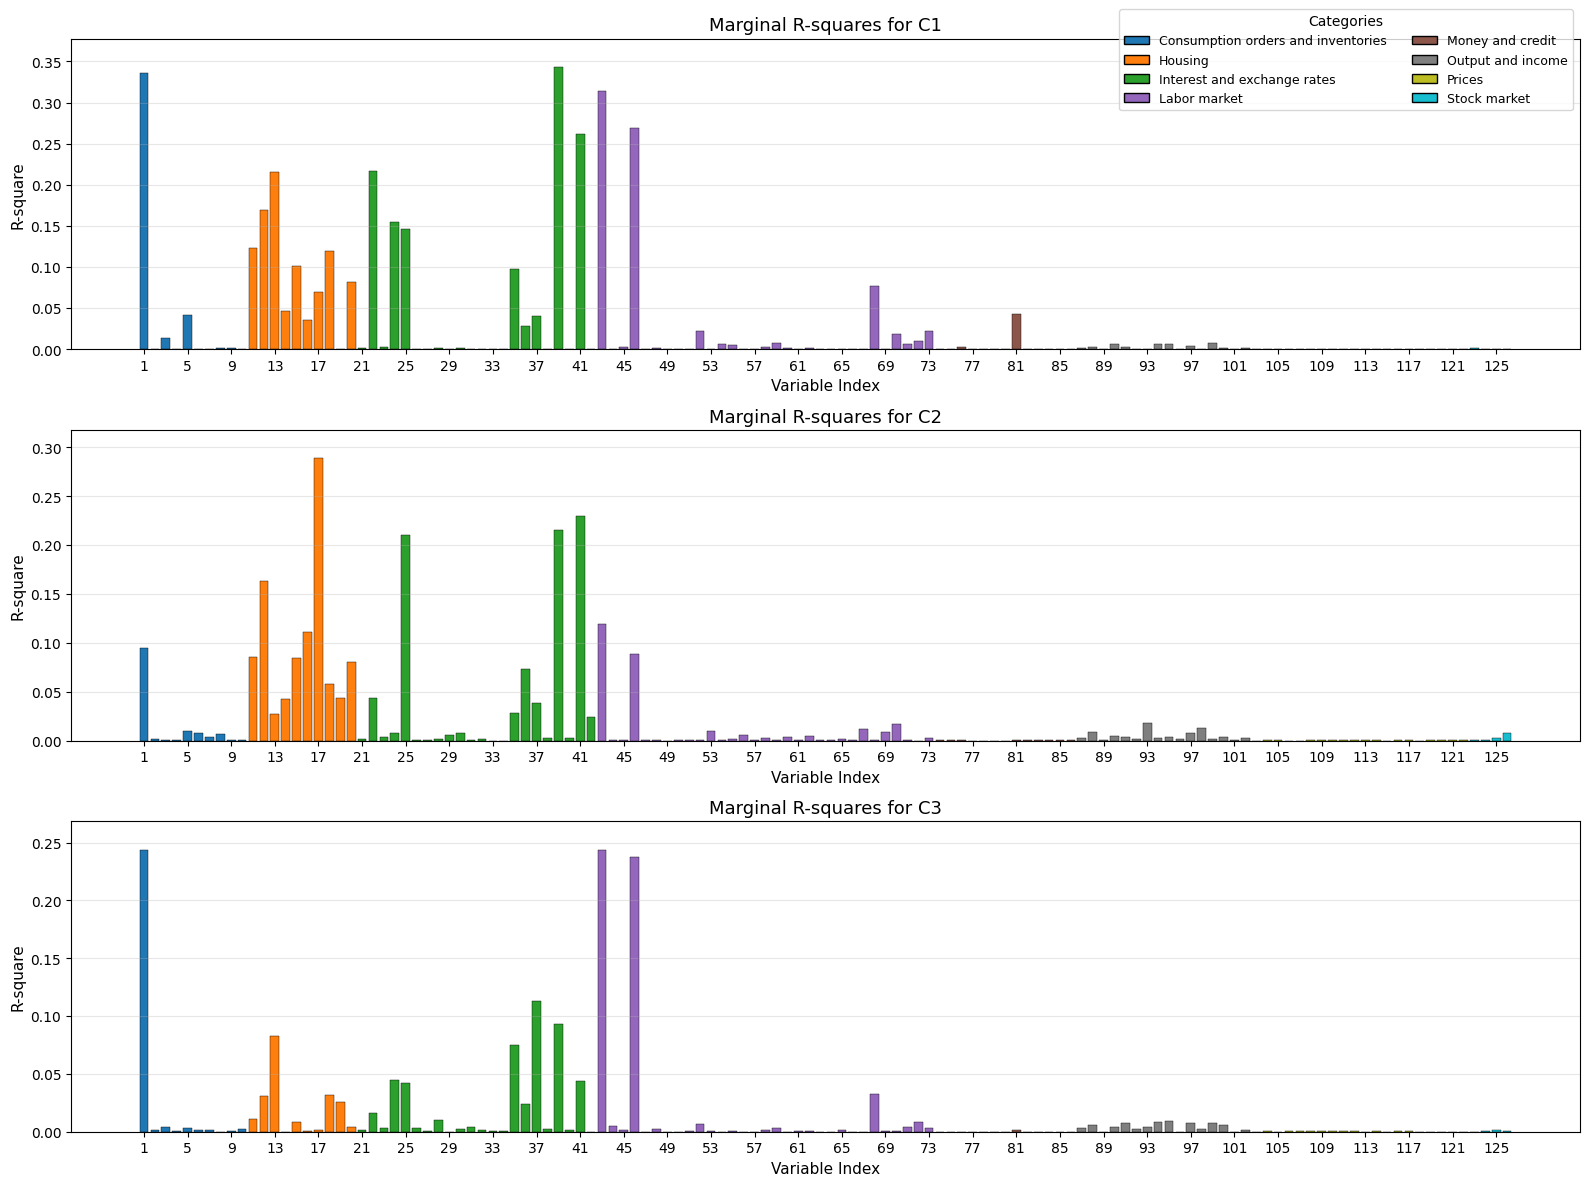

In [6]:
fred_md = load_fred_md(FIRST_DATE, LAST_DATE)

deep_ae_scores_monthly = deep_ae_scores_df.resample('MS').first()
pca_scores_monthly = pca_scores_df.resample('MS').first()

plot_marginal_r_squares(fred_md, deep_ae_scores_monthly)

# Latent space trajectories:

The plots show that the autoencoder has learned a more structured data manifold whereas PCA infers a more diffuse cloud.

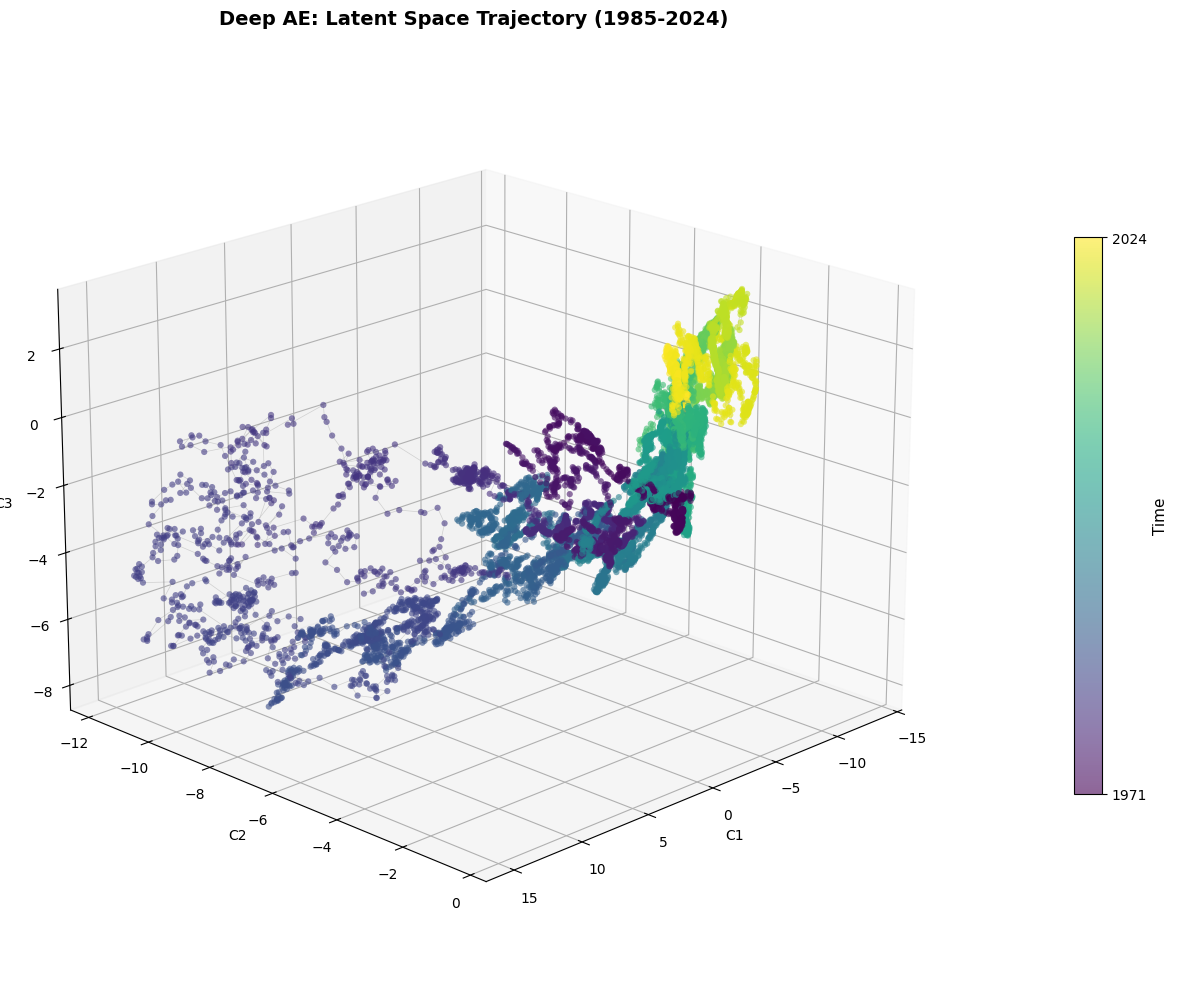

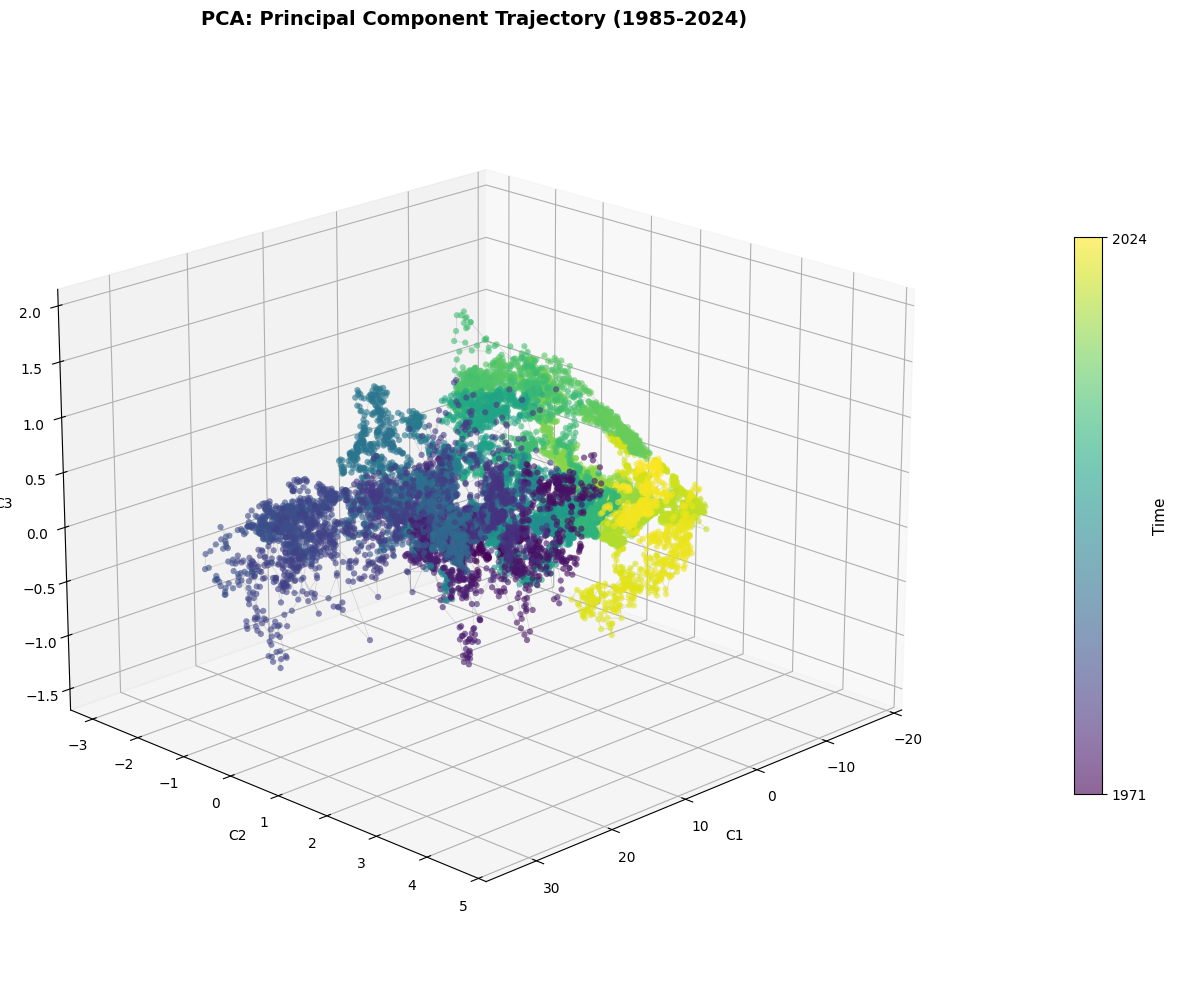

In [7]:
fig_static_deep = plot_latent_space_trajectory_3d_static(
    deep_ae_scores_df,
    title="Deep AE: Latent Space Trajectory (1985-2024)"
)
plt.show()

fig_static_pca = plot_latent_space_trajectory_3d_static(
    pca_scores_df,
    title="PCA: Principal Component Trajectory (1985-2024)"
)
plt.show()

# Robustness to seed choice

To verify that the results above are /somewhat/ robust to different seeds the analysis is rerun for multiple seeds.

In [ ]:
def run_multi_seed_analysis(y_normalized, n_seeds=10):
    """Run deep AE with multiple random seeds to assess stability."""
    results = {
        'encoders': [],
        'autoencoders': [],
        'histories': [],
        'scores_dfs': [],
        'reconstruction_errors': [],
        'seed_numbers': []
    }
    
    for seed in range(n_seeds):
        print(f"\n{'='*60}")
        print(f"Running seed {seed}...")
        print(f"{'='*60}")
        
        # Set seed
        set_random_seed(seed)
        
        # Train model
        encoder, ae, history = deepNonlinearAE(
            y_normalized, 
            dimension=3,
            hidden_dims=[64, 32, 16],
            learning_rate=1e-3,
            regularization=1e-5,
            epochs=100,
            activation='relu'
        )
        
        # Extract scores
        scores = get_deep_ae_scores(encoder, y_normalized)
        scores_df = pd.DataFrame(
            scores,
            index=yield_data.index,
            columns=['C1', 'C2', 'C3']
        )
        
        # Store results
        results['encoders'].append(encoder)
        results['autoencoders'].append(ae)
        results['histories'].append(history)
        results['scores_dfs'].append(scores_df)
        results['reconstruction_errors'].append(history.history['loss'][-1])
        results['seed_numbers'].append(seed)
        
    return results

# Run analyis
multi_seed_results = run_multi_seed_analysis(y_normalized, n_seeds=10)

Plotting marginal R² for each seed...

Plotting seed 0...


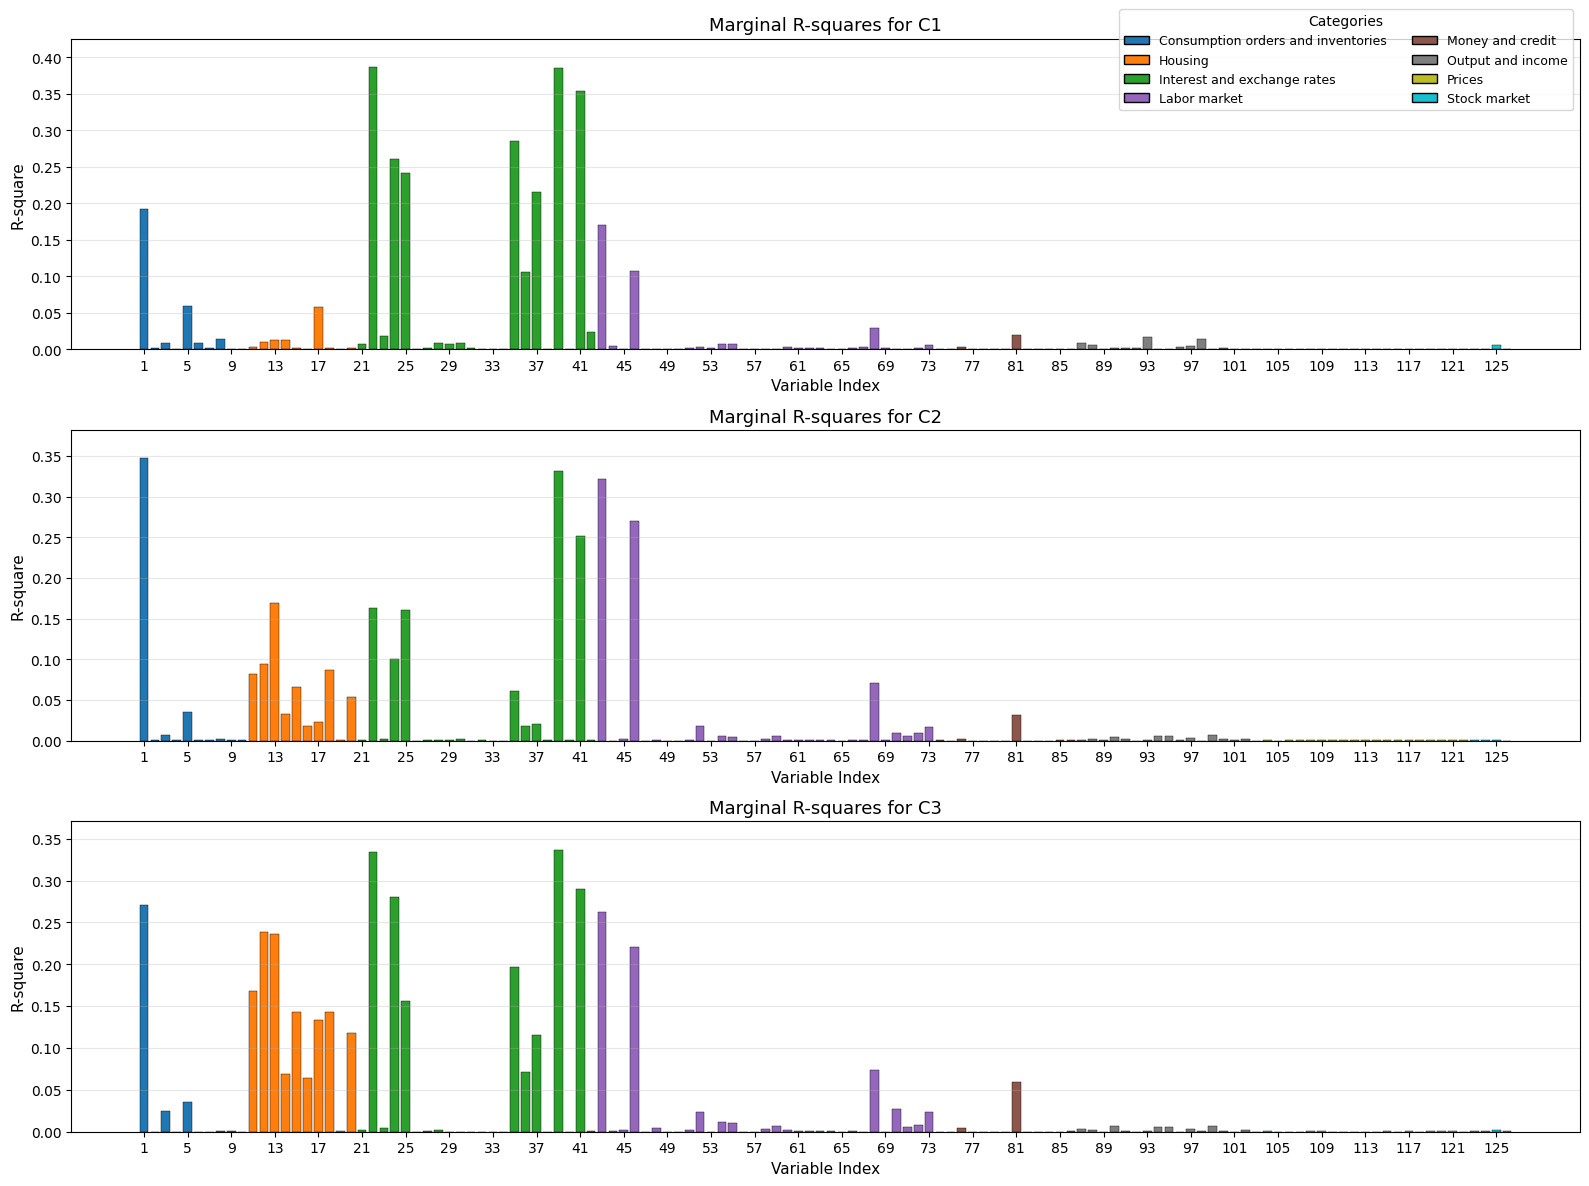


Plotting seed 1...


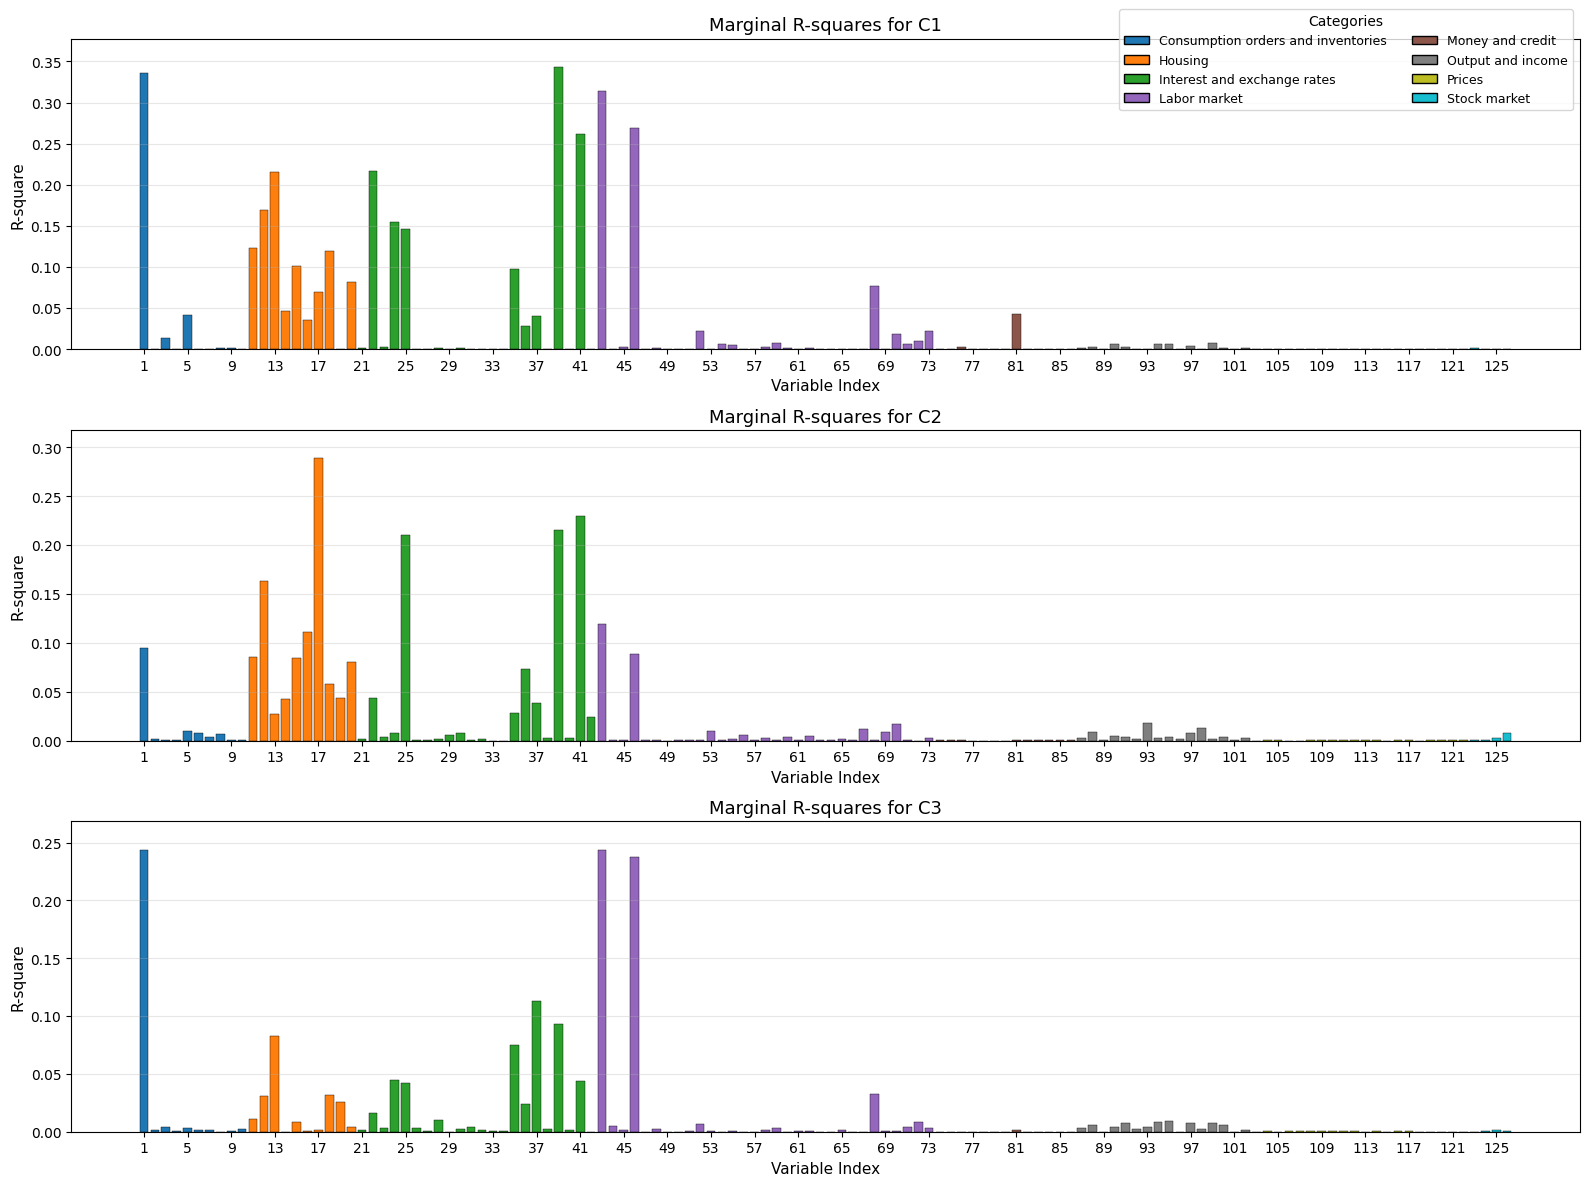


Plotting seed 2...


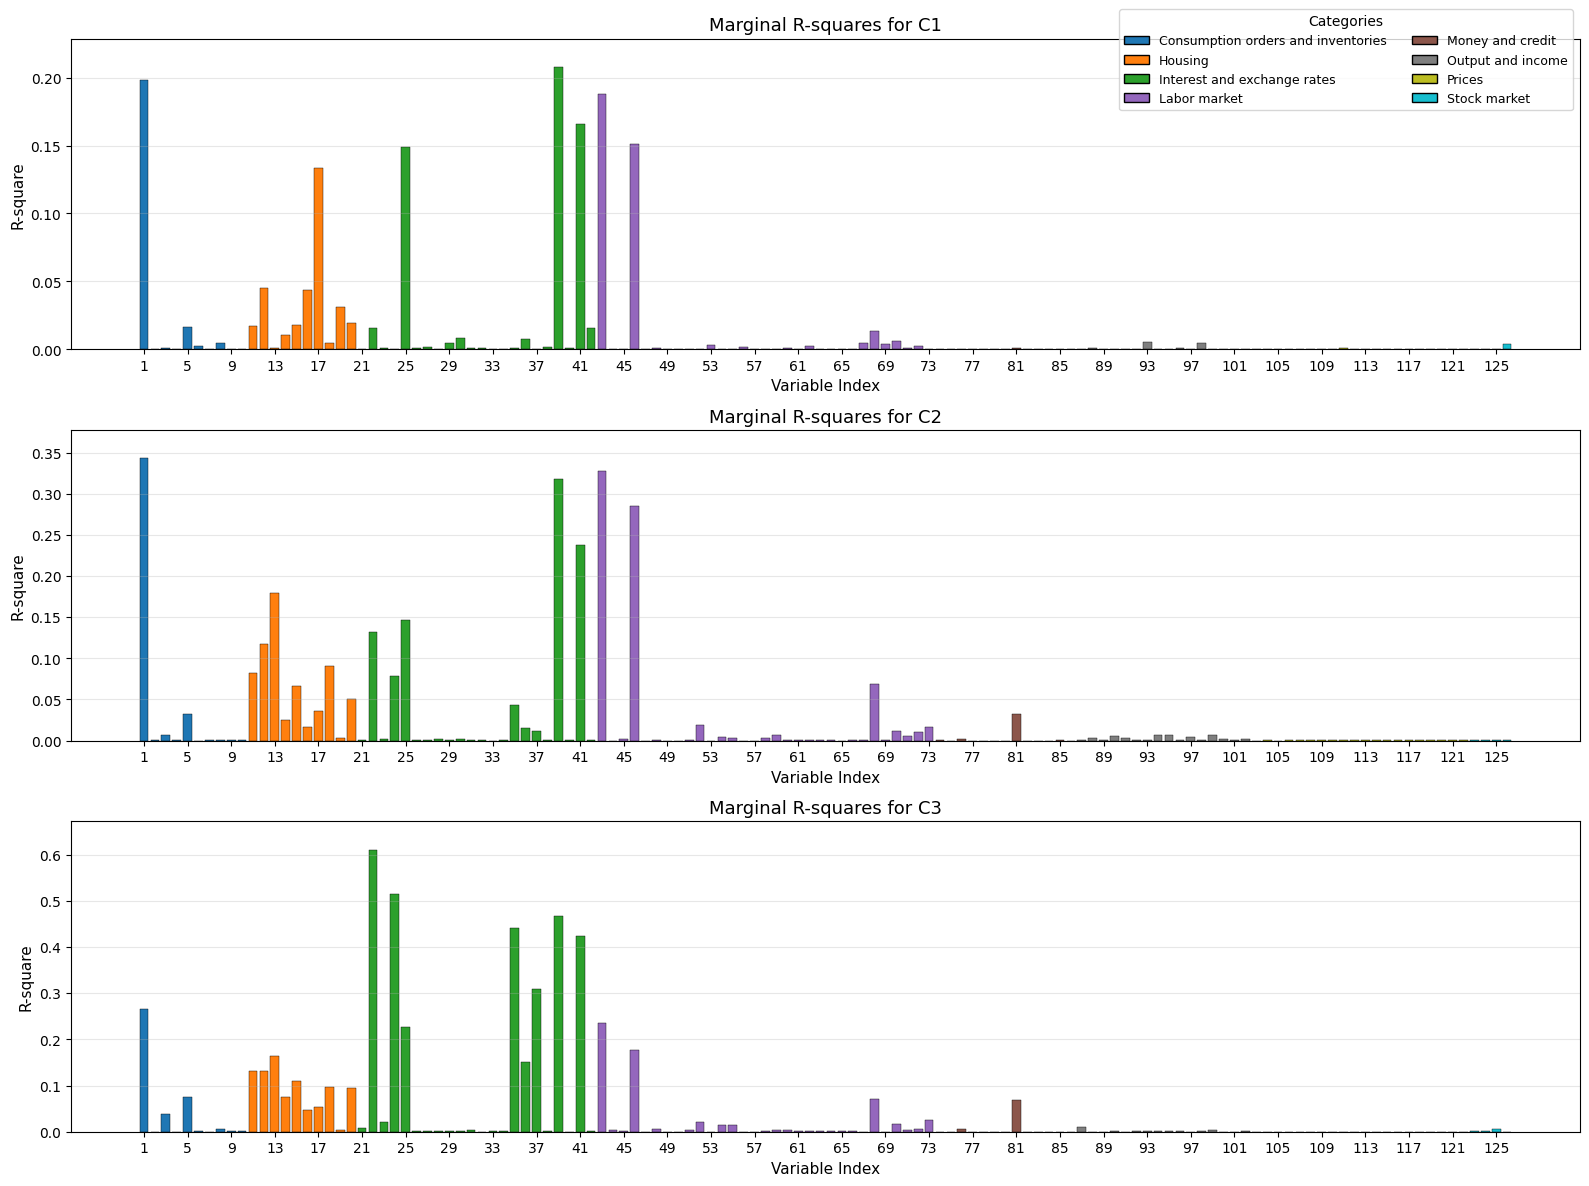


Plotting seed 3...


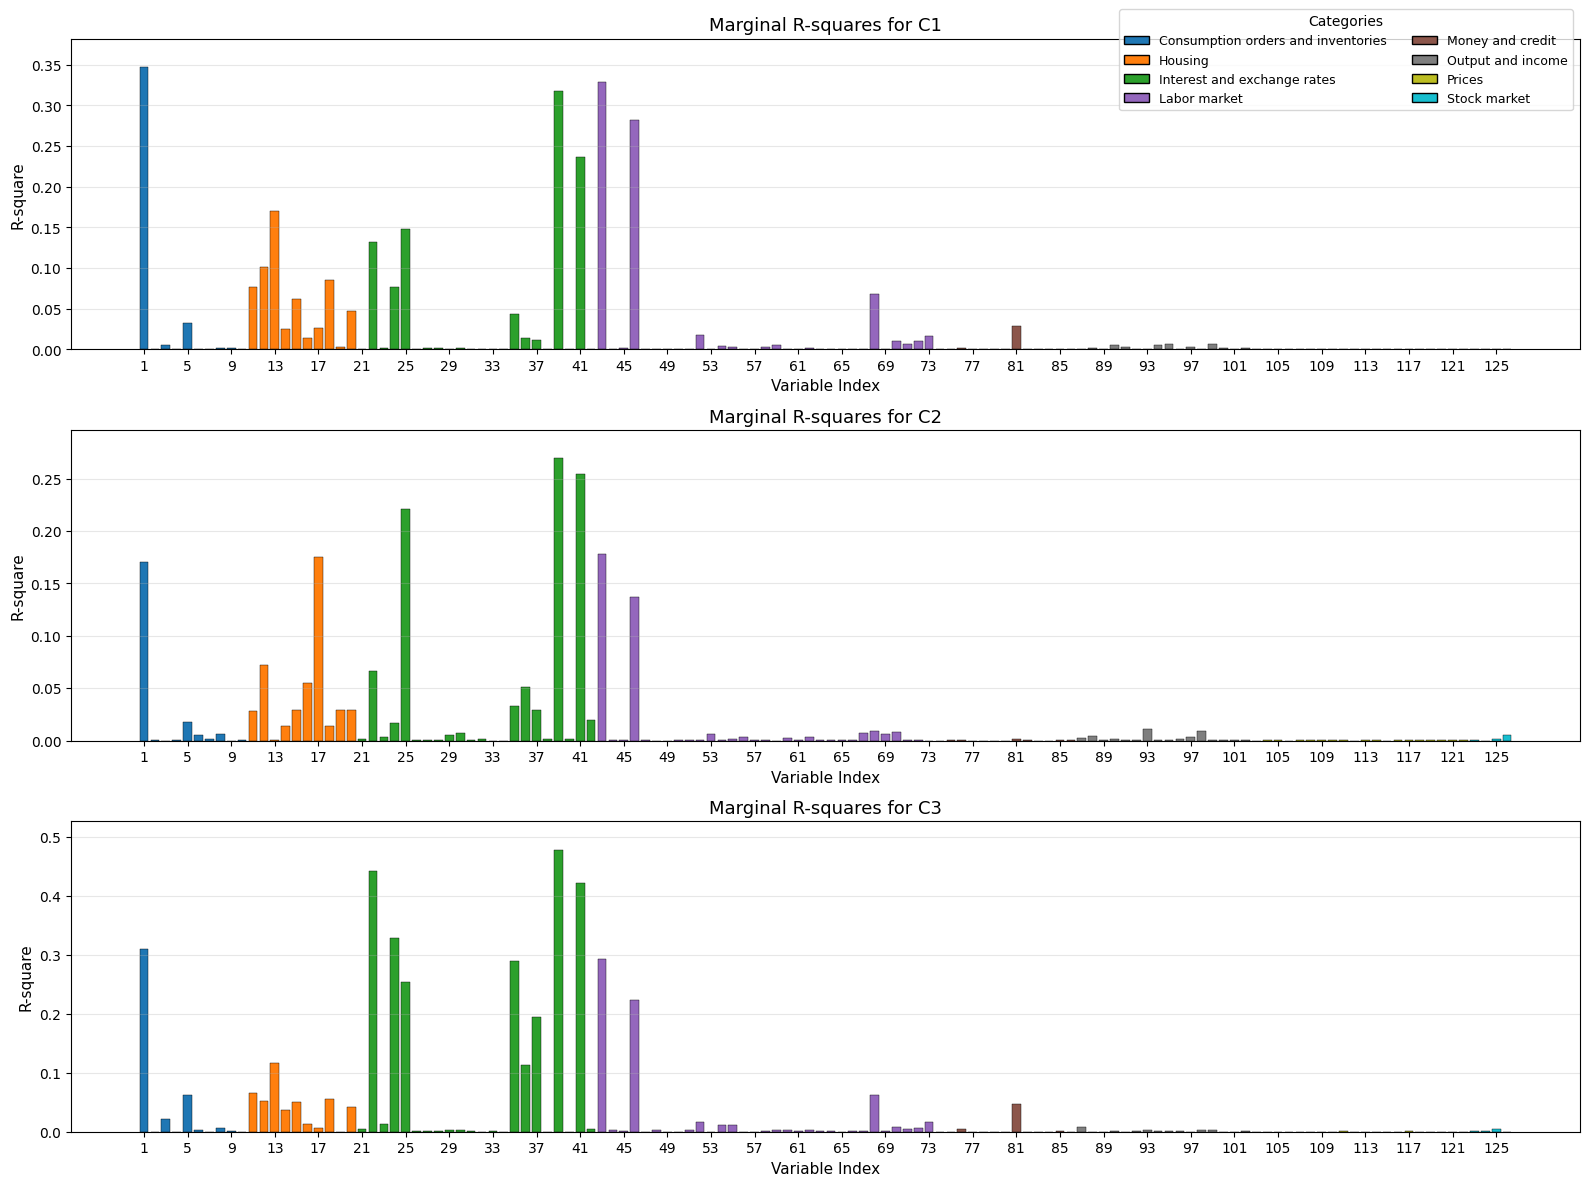


Plotting seed 4...


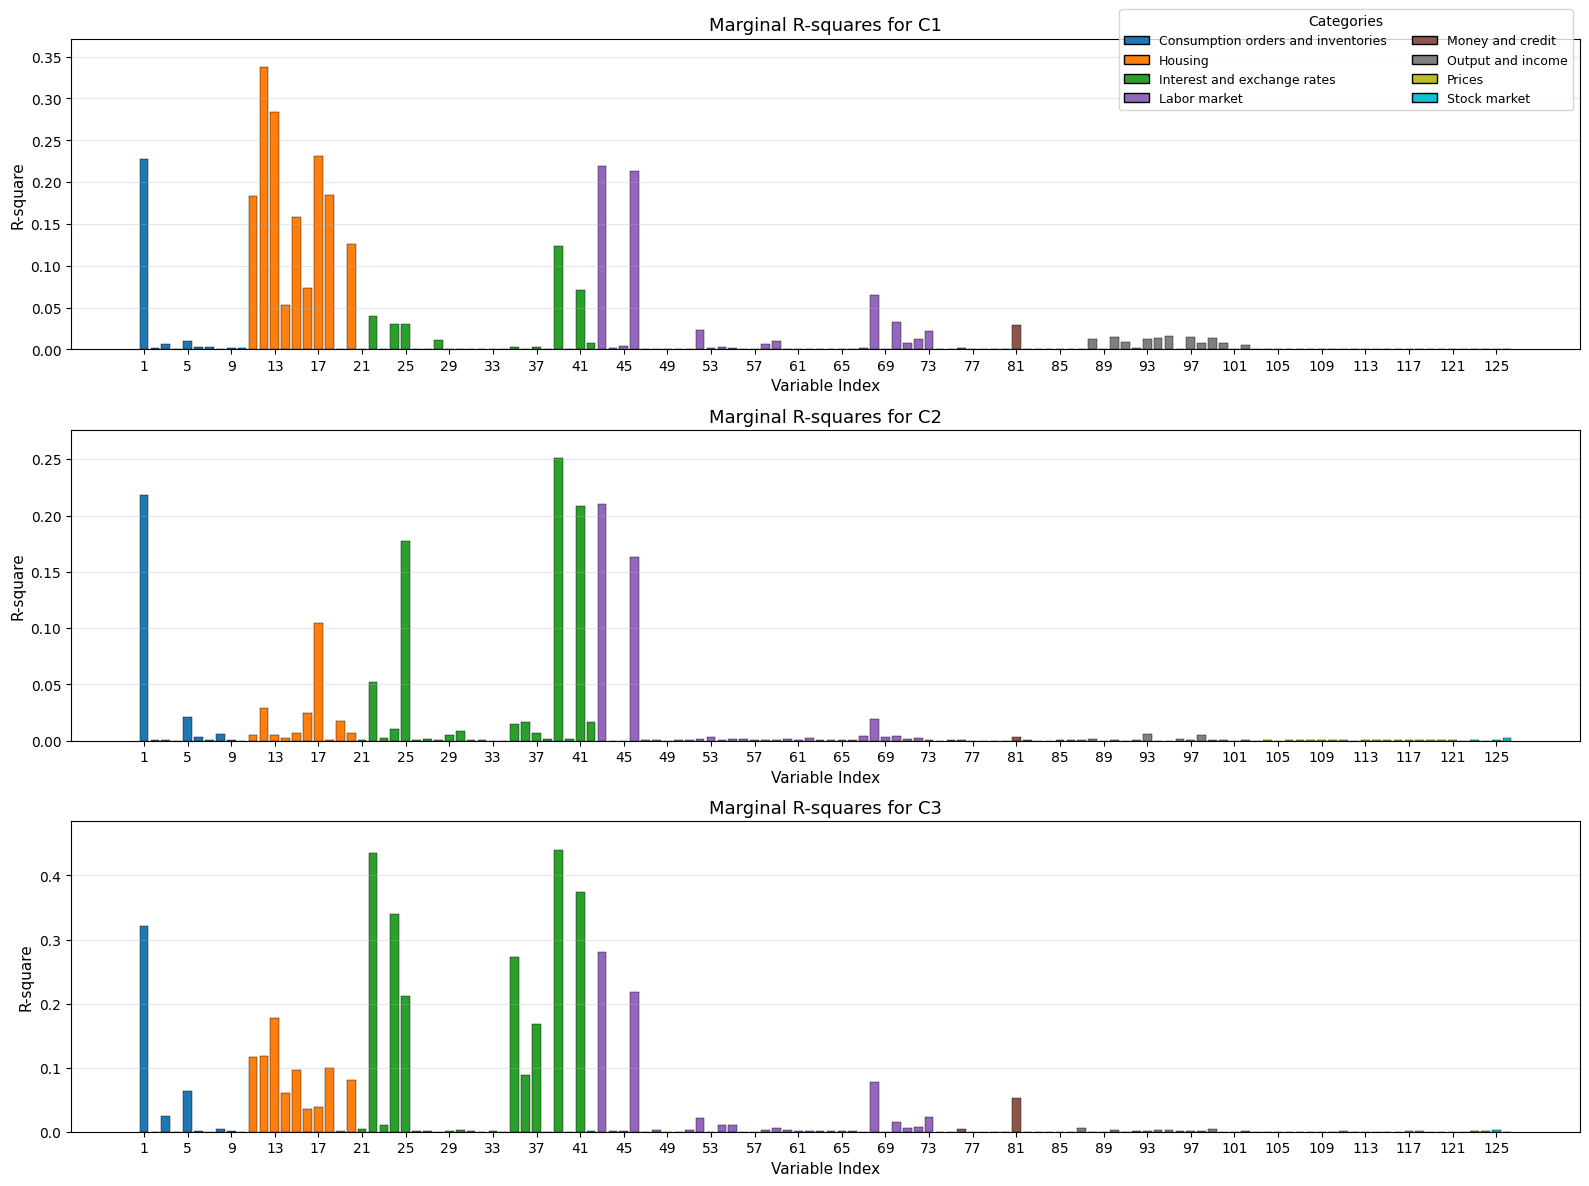


Plotting seed 5...


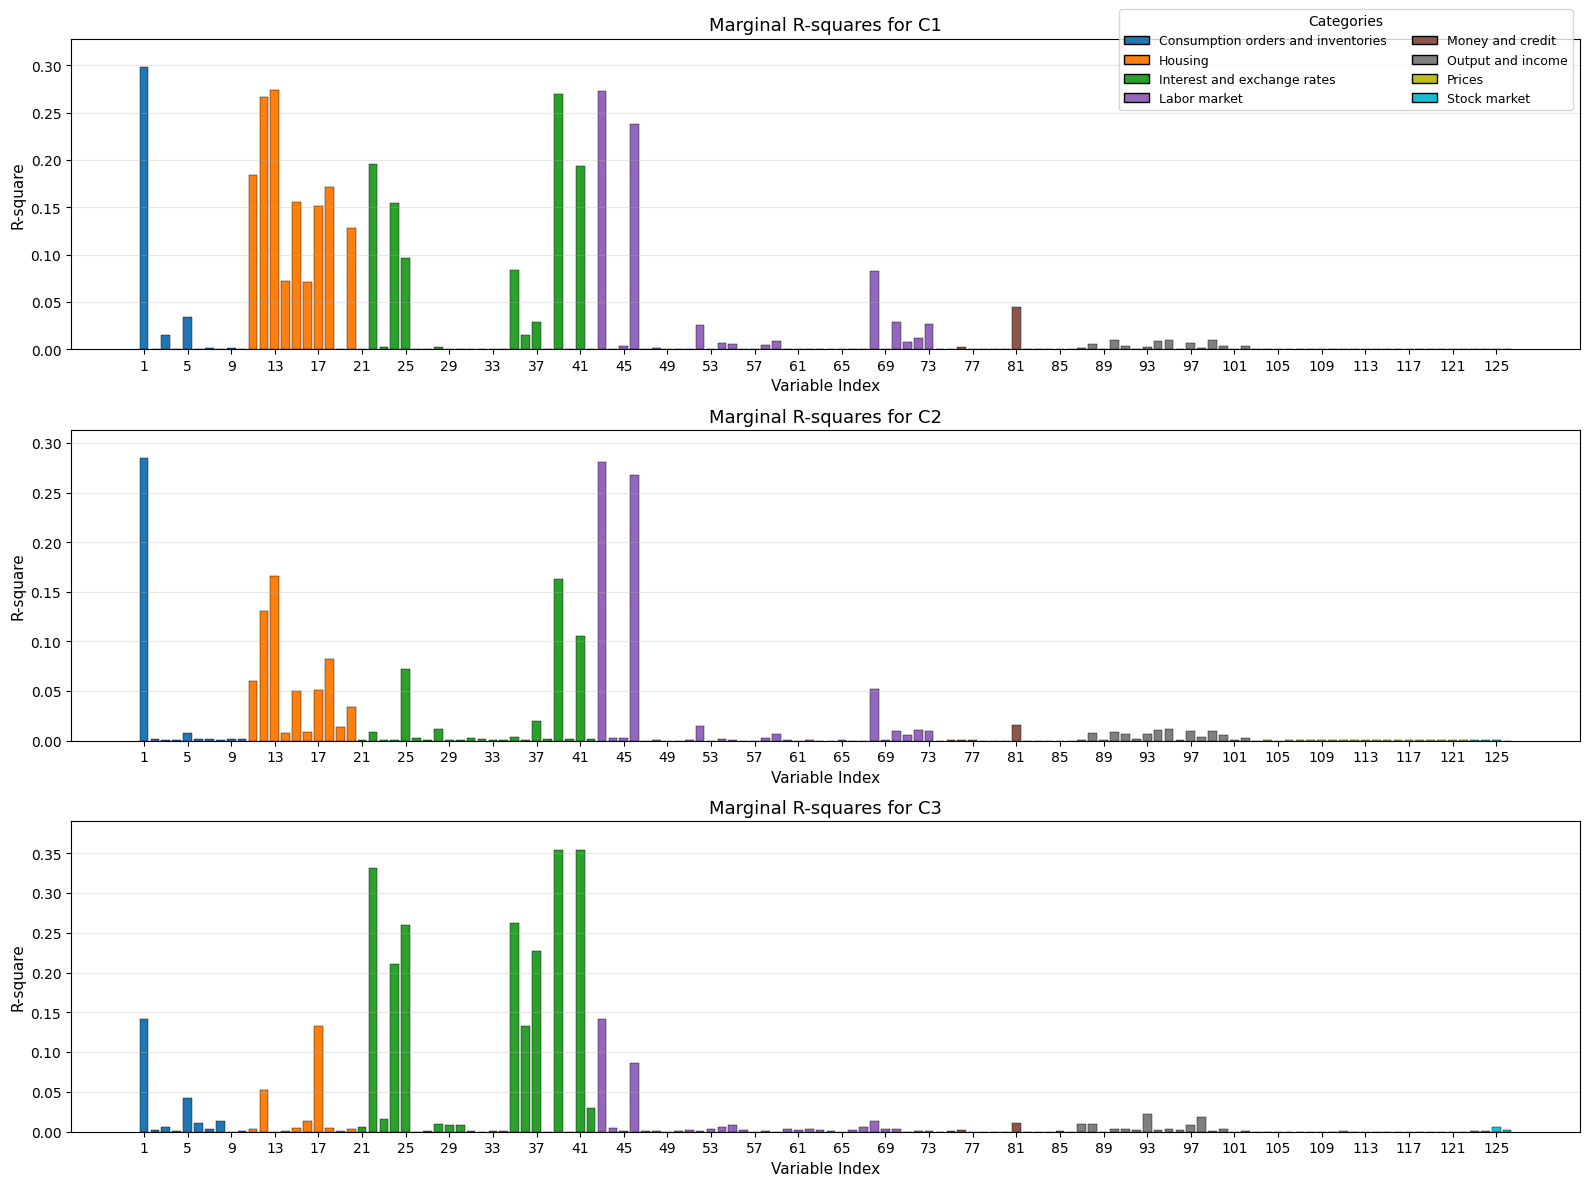


Plotting seed 6...


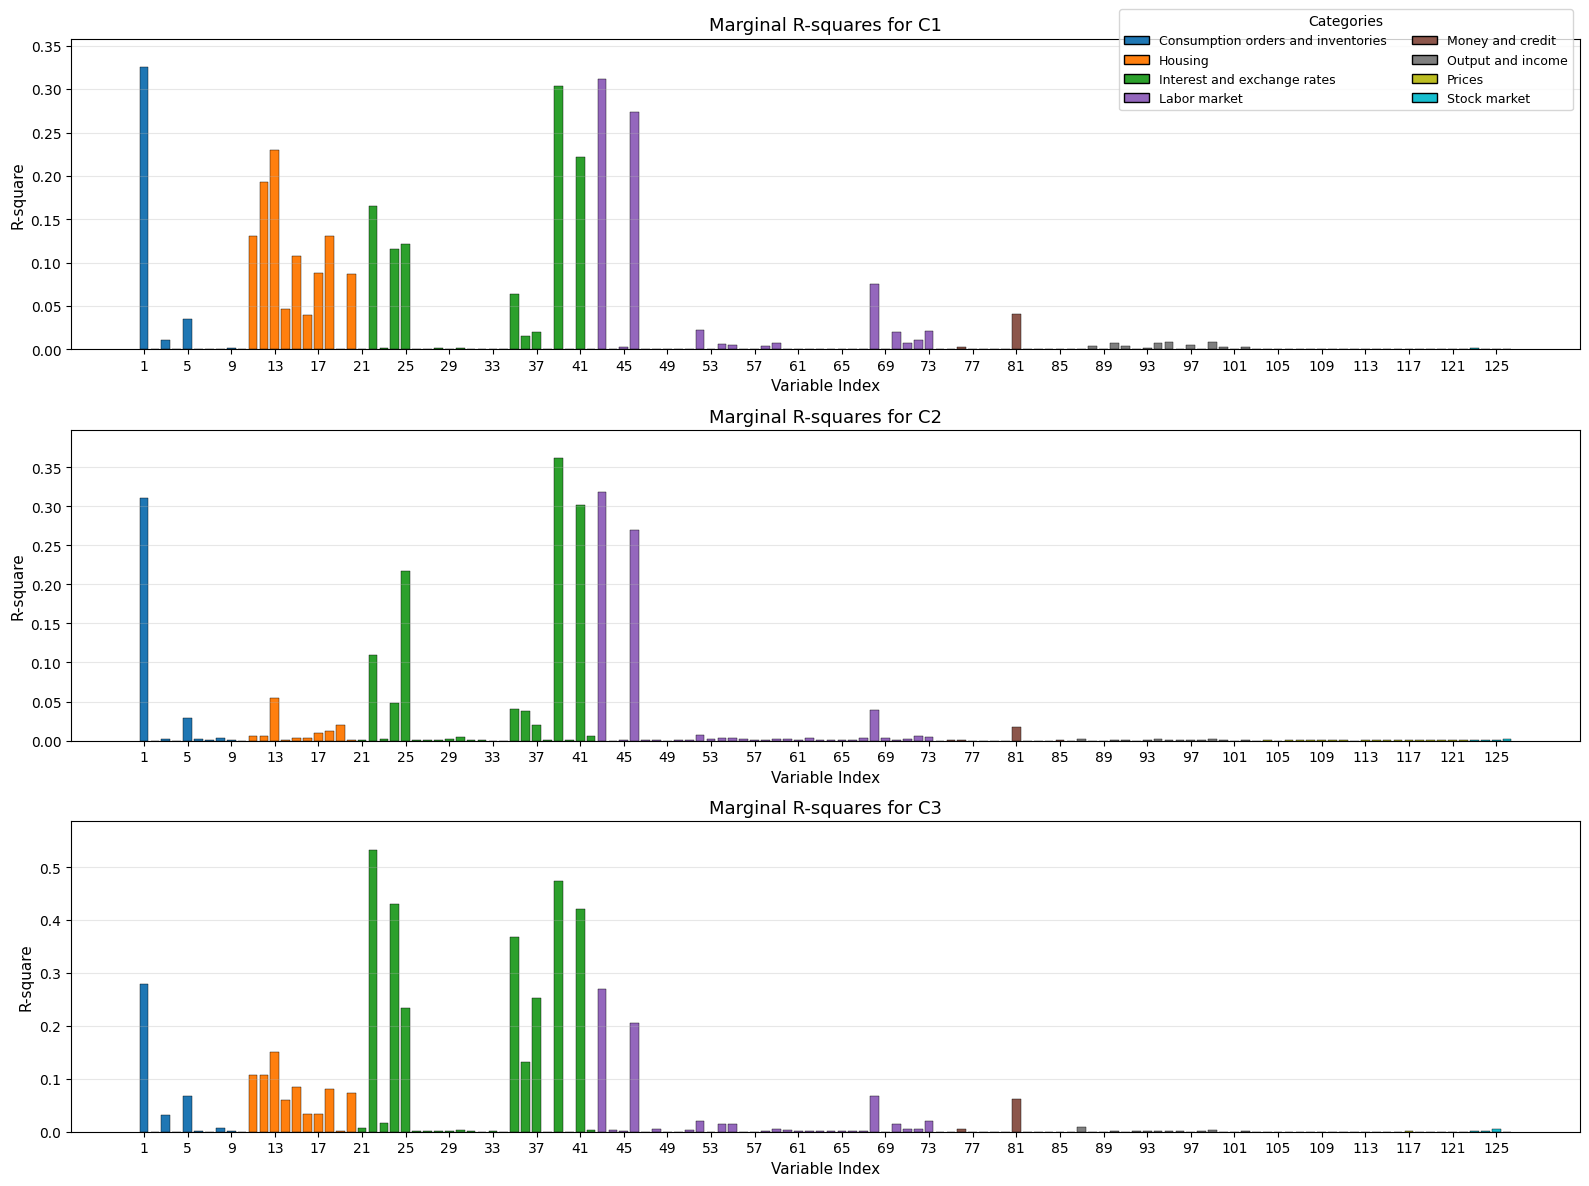


Plotting seed 7...


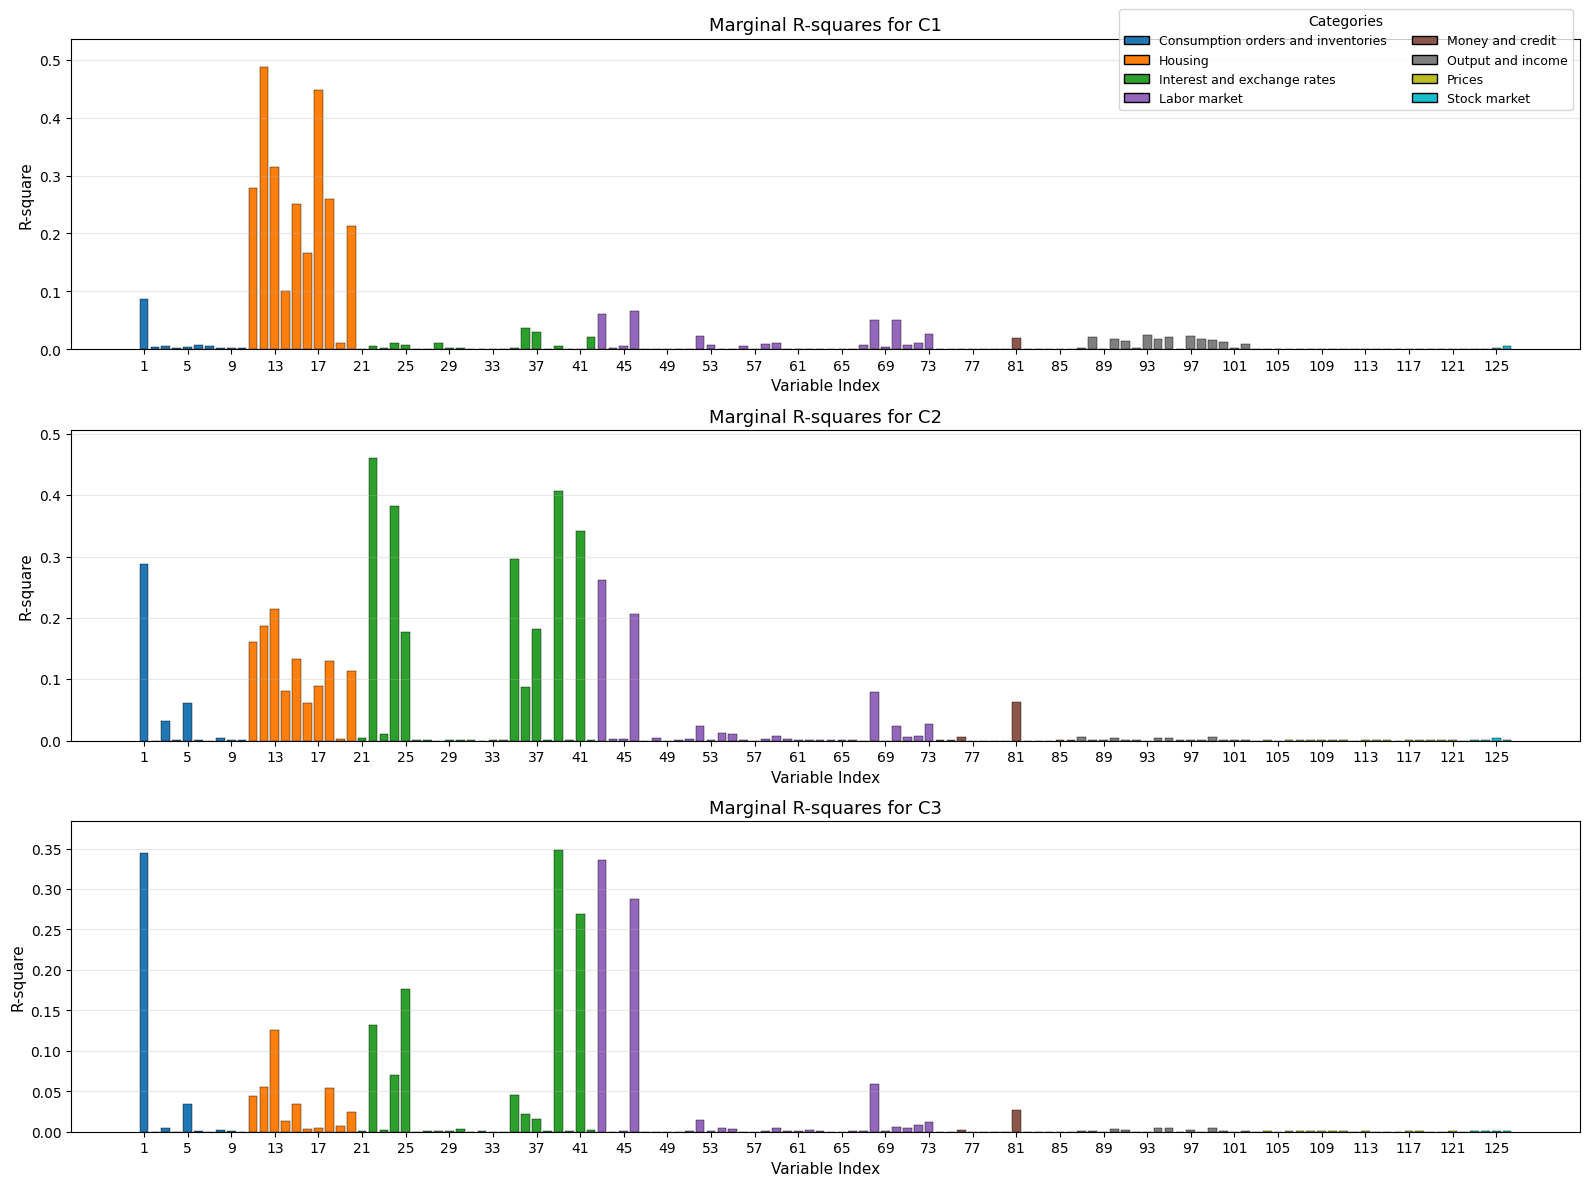


Plotting seed 8...


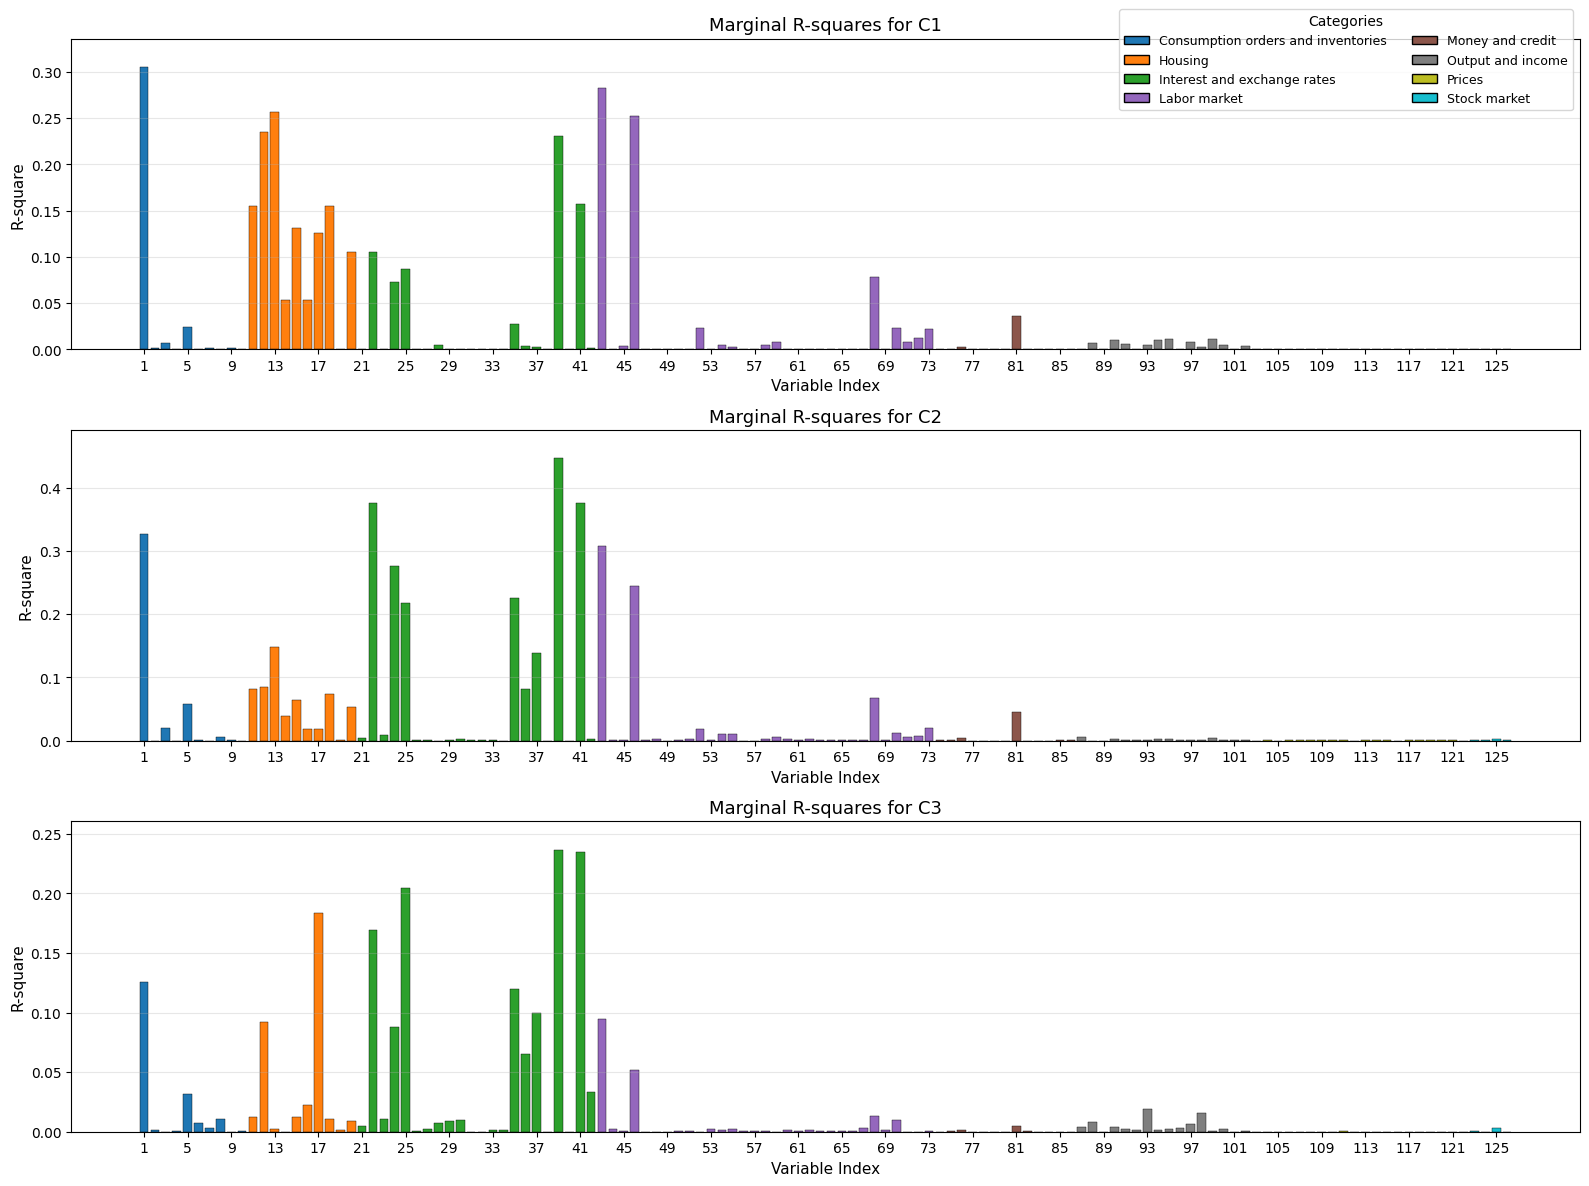


Plotting seed 9...


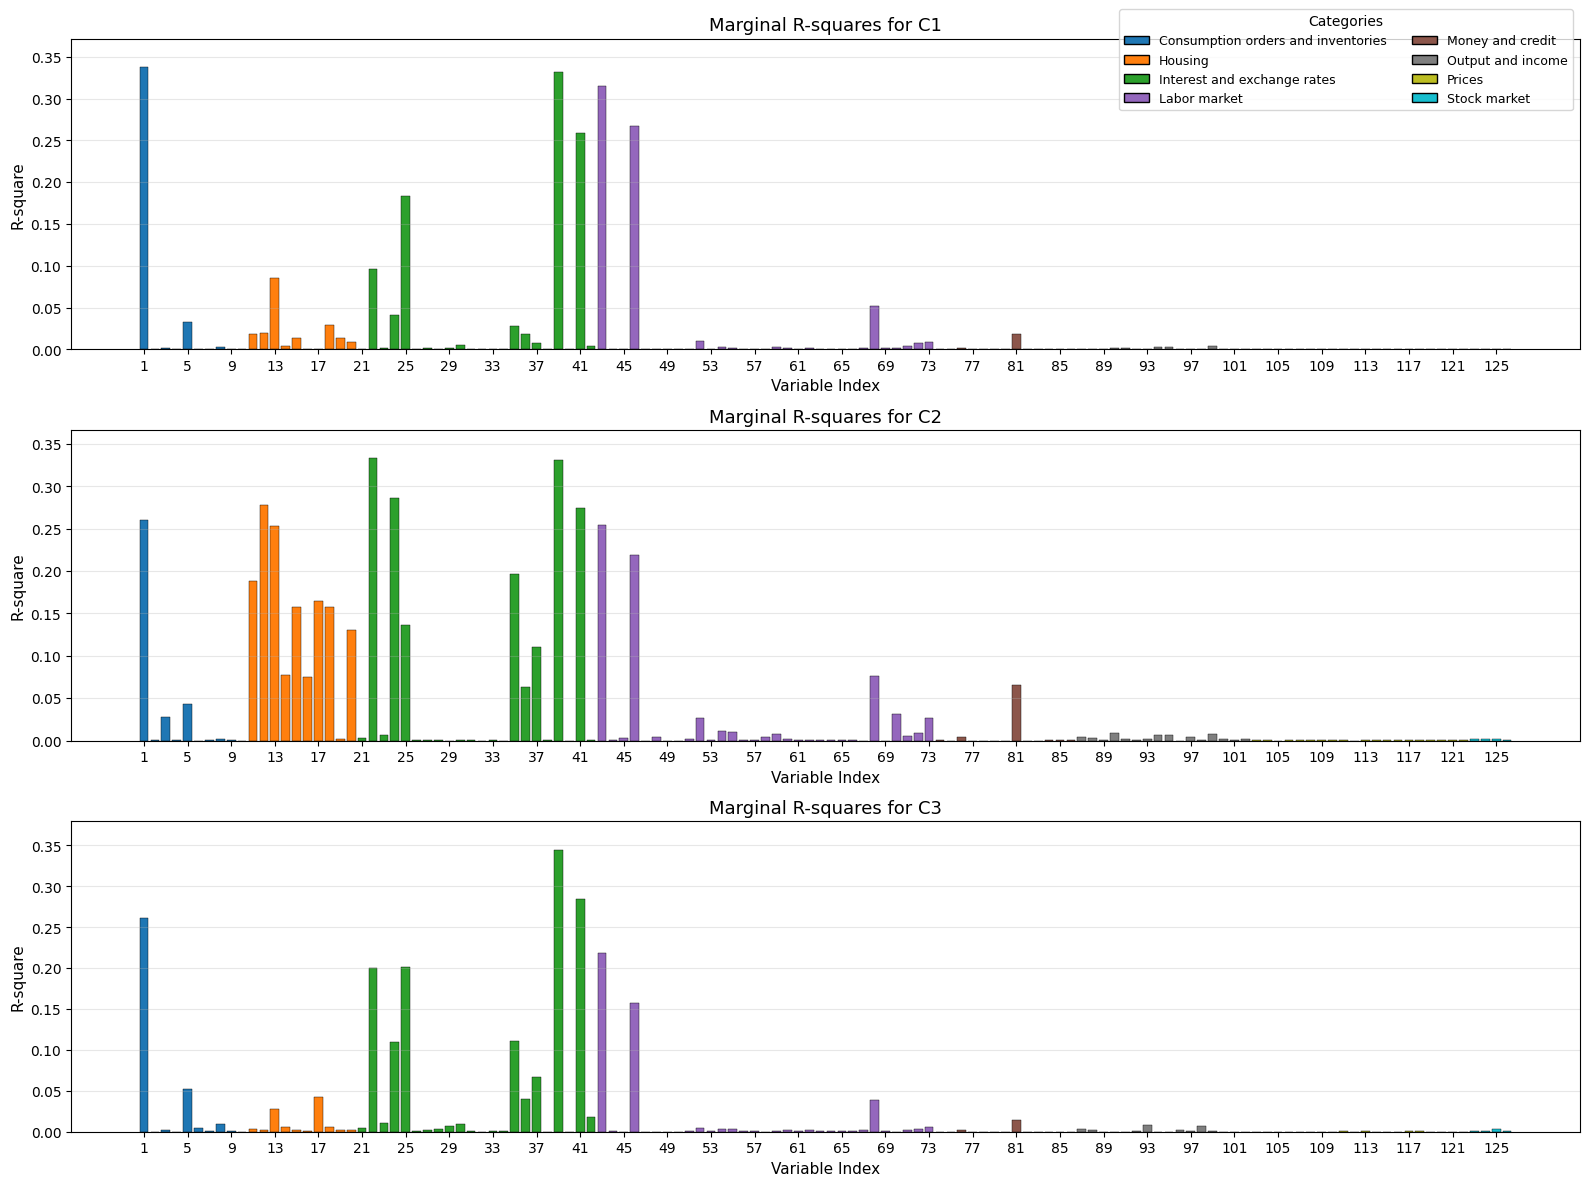

In [9]:
# Plot marginal R² for each seed to visualize stability
print("Plotting marginal R² for each seed...")

# Create subplots for all seeds
# n_seeds = len(multi_seed_results['scores_dfs'])
# n_cols = 2
# n_rows = int(np.ceil(n_seeds / n_cols))

# fig = plt.figure(figsize=(10, 8 * n_rows))

for seed_idx, scores_df in enumerate(multi_seed_results['scores_dfs']):
    print(f"\nPlotting seed {seed_idx}...")
    scores_monthly = scores_df.resample('MS').first()

    # Plot marginal R² for this seed
    plot_marginal_r_squares(fred_md, scores_monthly)